# NLCD & TCC

## Packages and working directory 

In [27]:
import os
import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt

from rasterio.mask import mask
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS

from shapely.geometry import box
from matplotlib.colors import ListedColormap, BoundaryNorm


# Set the working directory
wd = 'E:/_data/LULC/NLCD_USA/'
os.chdir(wd)

dir_output = r'D:\natcap\invest-mental-health\data\lc_scenarios'

lc_baseline = os.path.join('nlcd_2019_land_cover_l48_20210604', 'nlcd_2019_land_cover_l48_20210604.img')
treeCanopy = os.path.join('NLCD_TCC', 'nlcd_tcc_conus_2021_v2021-4.tif')

lc_b_output = os.path.join(dir_output, 'nlcd_2019_land_cover.tif')

print(lc_baseline)
print(treeCanopy)

nlcd_2019_land_cover_l48_20210604\nlcd_2019_land_cover_l48_20210604.img
NLCD_TCC\nlcd_tcc_conus_2021_v2021-4.tif


## AOI

In [22]:
# Load the shapefile
dir_shp = 'D:/natcap/invest-mental-health/data'
shapefile_path = os.path.join(dir_shp, 'cb_2019_us_county_500k_06075_clip.shp')
aoi = gpd.read_file(shapefile_path)


# Load the San Francisco boundary (e.g., from a shapefile or GeoJSON)
sf_boundary = gpd.read_file(shapefile_path)

## Data

In [23]:
code_dir = r"D:\natcap\invest-mental-health\code"

code_path = os.path.join(code_dir, "function_reproject_and_align.py")

## load function 
with open(code_path) as f:
    exec(f.read())

## NLCD data

### Color schedme 

In [24]:
# Define the NLCD color palette as a dictionary
nlcd_colors_hex = {    
    0: (0, 0, 0, 0),   # Transparent background
    11: "#476BA1",      # Open Water
    12: "#D1DEF8",      # Perennial Ice/Snow
    21: "#DEC5C5",      # Developed, Open Space
    22: "#D99282",      # Developed, Low Intensity
    23: "#EB0000",      # Developed, Medium Intensity
    24: "#AB0000",      # Developed, High Intensity
    31: "#B3AC9F",      # Barren Land
    41: "#68AB63",      # Deciduous Forest
    42: "#1c5f2c",      # Evergreen Forest
    43: "#B5C58F",      # Mixed Forest
    51: '#af963c',
    52: "#CCBA7C",      # Shrub/Scrub
    71: "#dfdfc2",      # Herbaceous
    72: '#d1d182',
    81: "#dcd939",      # Hay/Pasture
    82: "#ab6c28",      # Cultivated Crops
    90: "#b8d9eb",      # Woody Wetlands
    95: "#6c9fb8"       # Emergent Herbaceous Wetlands
}



# Define a more comprehensive NLCD color scheme
nlcd_colors = {
    0: (0, 0, 0, 0),          # No Data (Transparent)
    11: (71, 107, 161, 255),    # Open Water
    12: (209, 222, 248, 255),   # Perennial Ice/Snow
    21: (255, 255, 191, 255),   # Developed, Open Space
    22: (254, 196, 79, 255),    # Developed, Low Intensity
    23: (235, 0, 0, 255),       # Developed, Medium Intensity
    24: (171, 0, 0, 255),       # Developed, High Intensity
    31: (220, 220, 220, 255),   # Barren Land (Rock/Sand/Clay)
    41: (104,171,99, 255),      # Deciduous Forest
    42: (28, 95, 44, 255),      # Evergreen Forest 
    43: (116, 196, 118, 255),   # Mixed Forest
    51: (175, 150, 60, 255),
    52: (201, 222, 164, 255),   # Shrub/Scrub
    71: (217, 217, 112, 255),   # Grassland/Herbaceous
    72: (209, 209, 130, 255),
    81: (173, 220, 150, 255),   # Pasture/Hay
    82: (253, 174, 97, 255),    # Cultivated Crops
    90: (171, 217, 233, 255),   # Woody Wetlands
    95: (115, 115, 176, 255),   # Emergent Herbaceous Wetlands

}

# Multiply original codes by 10 and add additional colors for reclassified classes
extended_colors = {
    0: nlcd_colors[0],      # No Data (Transparent)
    110: nlcd_colors[11],   # Open Water
    120: nlcd_colors[12],   # Perennial Ice/Snow
    210: nlcd_colors[21],   # Developed, Open Space
    220: nlcd_colors[22],   # Developed, Low Intensity
    230: nlcd_colors[23],   # Developed, Medium Intensity
    240: nlcd_colors[24],   # Developed, High Intensity
    310: nlcd_colors[31],   # Barren Land (Rock/Sand/Clay)
    410: nlcd_colors[41],   # Deciduous Forest
    420: nlcd_colors[42],   # Evergreen Forest
    430: nlcd_colors[43],   # Mixed Forest
    520: nlcd_colors[52],   # Shrub/Scrub
    710: nlcd_colors[71],   # Grassland/Herbaceous
    810: nlcd_colors[81],   # Pasture/Hay
    820: nlcd_colors[82],   # Cultivated Crops
    900: nlcd_colors[90],   # Woody Wetlands
    950: nlcd_colors[95],   # Emergent Herbaceous Wetlands
    
    211: nlcd_colors[21],   # New class for 21*10 + 1
    212: (254, 196, 79, 255),    # New class for 21*10 + 2
    # 213: (252, 141, 89, 255),    # New class for 21*10 + 3
    213: (134,232,134, 255),    ## light red -> green
    
    221: nlcd_colors[22],   # New class for 22*10 + 1
    222: (254, 196, 79, 255),    # New class for 22*10 + 2
    # 223: (252, 141, 89, 255),    # New class for 22*10 + 3
    223: (198,249,214, 255),     ## light red -> green
    
    311: nlcd_colors[31],        # New class for 31*10 + 1
    312: (245, 245, 245, 255),   # New class for 31*10 + 2
    313: (200, 200, 200, 255),   # New class for 31*10 + 3
    
    411: nlcd_colors[41],     # New class for 41*10 + 1
    412: (93,153,89, 255),      # New class for 41*10 + 2
    413: (83,136,79, 255),   # New class for 41*10 + 3
    421: nlcd_colors[42],     # New class for 42*10 + 1
    422: (25,85,39, 255),      # New class for 42*10 + 2
    423: (22,76,35, 255),   # New class for 42*10 + 3
    431: nlcd_colors[43],     # New class for 43*10 + 1
    432: (162,177,128, 255),      # New class for 43*10 + 2
    433: (144,157,114, 255),   # New class for 43*10 + 3
}


### clip lc baseline 

In [ ]:
# Ensure the shapefile's CRS matches the raster's CRS
with rasterio.open(lc_baseline) as src_lc:
    nlcd_crs = src_lc.crs
    if sf_boundary.crs != nlcd_crs:
        sf_boundary = sf_boundary.to_crs(nlcd_crs)

# Load the NLCD raster
with rasterio.open(lc_baseline) as src_lc:
    # Clip the raster using the shapefile
    lc_baseline_clipped, clipped_transform = mask(src_lc, sf_boundary.geometry, crop=True)
    
    # Update metadata with the new transform and dimensions
    clipped_meta = src_lc.meta.copy()
    clipped_meta.update({
        "driver": "GTiff",
        "height": lc_baseline_clipped.shape[1],
        "width": lc_baseline_clipped.shape[2],
        "transform": clipped_transform
    })

    # Save the clipped raster to a new file
    with rasterio.open(lc_b_output, "w", **clipped_meta) as dest:
        dest.write(lc_baseline_clipped)


## TCC data

In [73]:
# Load and clip the tree canopy raster to the San Francisco region
with rasterio.open(treeCanopy) as src_tc:
    crs_tc = src_tc.crs
    tree_canopy_clipped, tc_transform = mask(src_tc, sf_boundary.geometry, crop=True)
    tc_meta = src_tc.meta.copy()

# Update the metadata for the new clipped raster
tc_meta.update({
    "driver": "GTiff",
    "height": tree_canopy_clipped.shape[1],
    "width": tree_canopy_clipped.shape[2],
    "transform": tc_transform
})

   


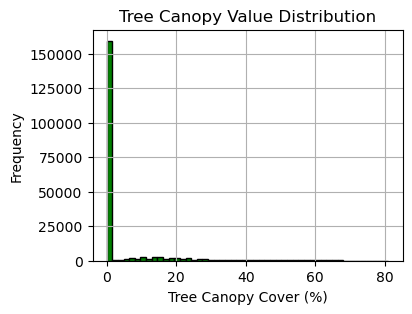

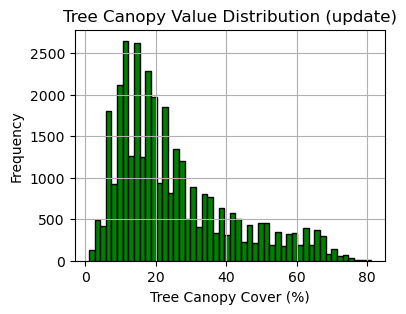

NLCD_TCC\nlcd_tcc_conus_2021_v2021-4_clipped.tif


c:\ProgramData\Anaconda3\Lib\site-packages\numpy\core\_asarray.py:130: RuntimeWarning: invalid value encountered in cast
  arr = array(a, dtype=dtype, order=order, copy=False, subok=subok)


In [74]:
# Assuming tree_canopy_clipped is the numpy array with the clipped tree canopy data

# Flatten the array to 1D for easier histogram plotting
tree_canopy_values = tree_canopy_clipped.flatten()

# Remove any no-data values or other invalid values (e.g., negatives or extremely high values)
# Assuming valid values are between 0 and 100 (adjust if needed)
valid_values = tree_canopy_values[(tree_canopy_values >= 0) & (tree_canopy_values <= 100)]

# Plot the histogram
plt.figure(figsize=(4, 3))
plt.hist(valid_values, bins=50, color='green', edgecolor='black')
plt.title('Tree Canopy Value Distribution')
plt.xlabel('Tree Canopy Cover (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Set values of 0 or > 100 to np.nan
tree_canopy_clipped = np.where((tree_canopy_clipped == 0) | (tree_canopy_clipped > 100), np.nan, tree_canopy_clipped)
# Plot the histogram, ignoring NaN values automatically
tree_canopy_values = tree_canopy_clipped.flatten()

# Remove NaN values (NaN values will be ignored by default in numpy operations)
valid_values = tree_canopy_values[~np.isnan(tree_canopy_values)]

# Plot the histogram
plt.figure(figsize=(4, 3))
plt.hist(valid_values, bins=50, color='green', edgecolor='black')
plt.title('Tree Canopy Value Distribution (update)')
plt.xlabel('Tree Canopy Cover (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()




# Save the clipped landcover raster
treeCanopy_clipped_path = treeCanopy.replace('.tif', '_clipped.tif'); print(treeCanopy_clipped_path)
with rasterio.open(treeCanopy_clipped_path, 'w', **tc_meta) as dst:
    dst.write(tree_canopy_clipped)

### Reproject and align TCC to NLCD

In [ ]:
# Paths to the input and output files
tree_canopy_path = treeCanopy_clipped_path
land_cover_path = lc_b_output
treeCanopy_align_path = treeCanopy_clipped_path.replace('.tif', '_reprojected_aligned.tif'); print(treeCanopy_align_path)

# Open the land cover raster to get its CRS, transform, and dimensions
with rasterio.open(land_cover_path) as land_cover_src:
    land_cover_crs = land_cover_src.crs
    land_cover_transform = land_cover_src.transform
    land_cover_shape = (land_cover_src.height, land_cover_src.width)
    
    # Open the tree canopy raster
    with rasterio.open(tree_canopy_path) as tree_canopy_src:
        # Calculate the transform and dimensions for the target CRS (same as land cover)
        transform, width, height = calculate_default_transform(
            tree_canopy_src.crs, land_cover_crs,
            tree_canopy_src.width, tree_canopy_src.height,
            *tree_canopy_src.bounds)

        # Create metadata for the output file
        kwargs = tree_canopy_src.meta.copy()
        kwargs.update({
            'crs': land_cover_crs,
            'transform': land_cover_transform,  # Align to land cover transform
            'width': land_cover_shape[1],
            'height': land_cover_shape[0]
        })

        # Reproject and align the tree canopy raster
        with rasterio.open(treeCanopy_align_path, 'w', **kwargs) as dst:
            for i in range(1, tree_canopy_src.count + 1):
                reproject(
                    source=rasterio.band(tree_canopy_src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=tree_canopy_src.transform,
                    src_crs=tree_canopy_src.crs,
                    dst_transform=land_cover_transform,
                    dst_crs=land_cover_crs,
                    resampling=Resampling.bilinear  # Choose appropriate resampling method
                )

print(f"Reprojected and aligned tree canopy raster saved to \n{treeCanopy_align_path}")

print(land_cover_src.crs)
print('...\n')
print(dst.crs)


NLCD_TCC\nlcd_tcc_conus_2021_v2021-4_clipped_reprojected_aligned.tif
Reprojected and aligned tree canopy raster saved to 
NLCD_TCC\nlcd_tcc_conus_2021_v2021-4_clipped_reprojected_aligned.tif
PROJCS["Albers Conical Equal Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
...

PROJCS["Albers Conical Equal Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.01745329

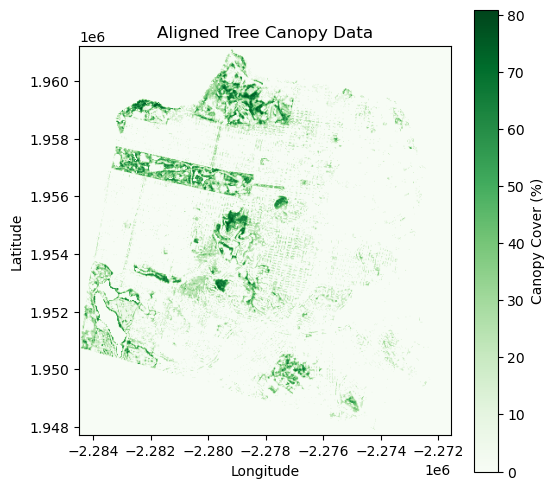

In [76]:
# Load the aligned tree canopy raster
with rasterio.open(treeCanopy_align_path) as src:
    tree_canopy_aligned = src.read(1)  # Read the first (and likely only) band
    transform = src.transform
    crs = src.crs

# Plot the aligned tree canopy raster
plt.figure(figsize=(6, 6))
plt.imshow(tree_canopy_aligned, cmap='Greens', extent=(transform[2], transform[2] + transform[0] * tree_canopy_aligned.shape[1], transform[5] + transform[4] * tree_canopy_aligned.shape[0], transform[5]))
# plt.imshow(tree_canopy_aligned, cmap='Greens')
plt.title('Aligned Tree Canopy Data')
plt.colorbar(label='Canopy Cover (%)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.axis('off')
plt.show()

### Viz NLCD and TCC

[ 0 11 21 22 23 24 31 41 42 43 52 71 81 82 90 95]


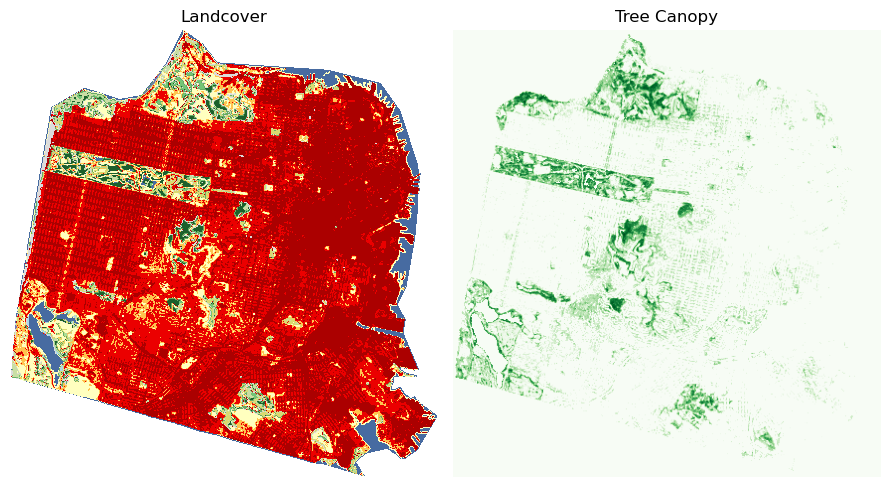

In [77]:
# Find unique land cover classes in the original and reclassified data
unique_classes_original = np.unique(landcover_clipped)
print(unique_classes_original)

# # Filter the NLCD colors dictionary to include only the present classes
# filtered_nlcd_colors = {k: nlcd_colors[k] for k in unique_classes_original if k in nlcd_colors}
# print(filtered_nlcd_colors)
# # Create a colormap and norm for only the present classes
# nlcd_colormap = ListedColormap([filtered_nlcd_colors[key] for key in sorted(filtered_nlcd_colors.keys())])
# nlcd_classes = np.array(sorted(filtered_nlcd_colors.keys()))
# nlcd_norm = plt.Normalize(vmin=nlcd_classes.min(), vmax=nlcd_classes.max())


original_codes = np.unique(landcover_clipped)
original_cmap_colors = np.array([nlcd_colors[code] for code in original_codes]) / 255.0
nlcd_colormap = ListedColormap(original_cmap_colors)
original_boundaries = np.concatenate(([unique_classes_original[0] - 0.5], unique_classes_original + 0.5))
nlcd_norm = BoundaryNorm(original_boundaries, nlcd_colormap.N)


# Visualize the clipped rasters side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 9))

# Display the landcover raster
ax1.imshow(landcover_clipped[0], cmap=nlcd_colormap, norm=nlcd_norm)
ax1.set_title('Landcover')
ax1.axis('off')

# Display the tree canopy raster
ax2.imshow(tree_canopy_aligned, cmap='Greens')
ax2.set_title('Tree Canopy')
ax2.axis('off')

plt.tight_layout()
plt.show()

## Reclassification 

### Functions

In [78]:
def reclassify_landcover(landcover, treeCanopy):
    """
    Reclassify the land cover based on tree canopy cover.

    Parameters:
    landcover (numpy.ndarray): The land cover raster array.
    treeCanopy (numpy.ndarray): The tree canopy raster array.

    Returns:
    numpy.ndarray: The reclassified land cover array.
    """
    # Initialize the reclassified array with the same shape as the landcover, using uint16 to handle larger values
    reclassified = np.zeros_like(landcover, dtype=np.uint16)

    # Get a list of unique land cover codes
    unique_codes = np.unique(landcover)
    print(unique_codes)

    # Define the target land cover codes that need reclassification
    target_codes = [21, 22, 31, 41, 42, 43]

    # Reclassify the target land cover codes based on tree canopy cover
    for code in target_codes:
        if code in unique_codes:
            mask = (landcover == code)
            reclassified[mask & (treeCanopy <= 7)] = code * 10 + 1
            reclassified[mask & (treeCanopy > 7) & (treeCanopy <= 20)] = code * 10 + 2
            reclassified[mask & (treeCanopy > 20)] = code * 10 + 3

    # For all other land cover codes, multiply by 10
    for code in unique_codes:
        if code not in target_codes and code != 0:
            reclassified[landcover == code] = code * 10

    # Ensure that zero values remain zero
    reclassified[landcover == 0] = 0

    return reclassified


### Run and save reclassified NLCD

In [ ]:
# Load the land cover and tree canopy rasters
treeCanopy_path = treeCanopy_align_path
landcover_reclassified_path = lc_b_output.replace('.tif', '_reclassified.tif'); print(landcover_reclassified_path)


with rasterio.open(lc_b_output) as landcover_src:
    landcover = landcover_src.read(1)
    landcover_meta = landcover_src.meta

with rasterio.open(treeCanopy_path) as treeCanopy_src:
    treeCanopy = treeCanopy_src.read(1)

# Reclassify the land cover based on tree canopy cover
reclassified = reclassify_landcover(landcover, treeCanopy)

# Update the metadata for the output file to use uint16
landcover_meta.update(dtype=rasterio.uint16, count=1)

unique_codes_reclassified = np.unique(reclassified)
print(unique_codes_reclassified)

# Save the reclassified land cover raster
with rasterio.open(landcover_reclassified_path, 'w', **landcover_meta) as dst:
    dst.write(reclassified, 1)


print(f"Reclassified land cover saved to \n{landcover_reclassified_path}")


nlcd_2019_land_cover_l48_20210604\nlcd_2019_land_cover_l48_20210604_clipped_reclassified.tif
[ 0 11 21 22 23 24 31 41 42 43 52 71 81 82 90 95]
[  0 110 211 212 213 221 222 223 230 240 311 312 313 411 412 413 421 422
 423 431 432 433 520 710 810 820 900 950]
Reclassified land cover saved to 
nlcd_2019_land_cover_l48_20210604\nlcd_2019_land_cover_l48_20210604_clipped_reclassified.tif


### Plot side by side

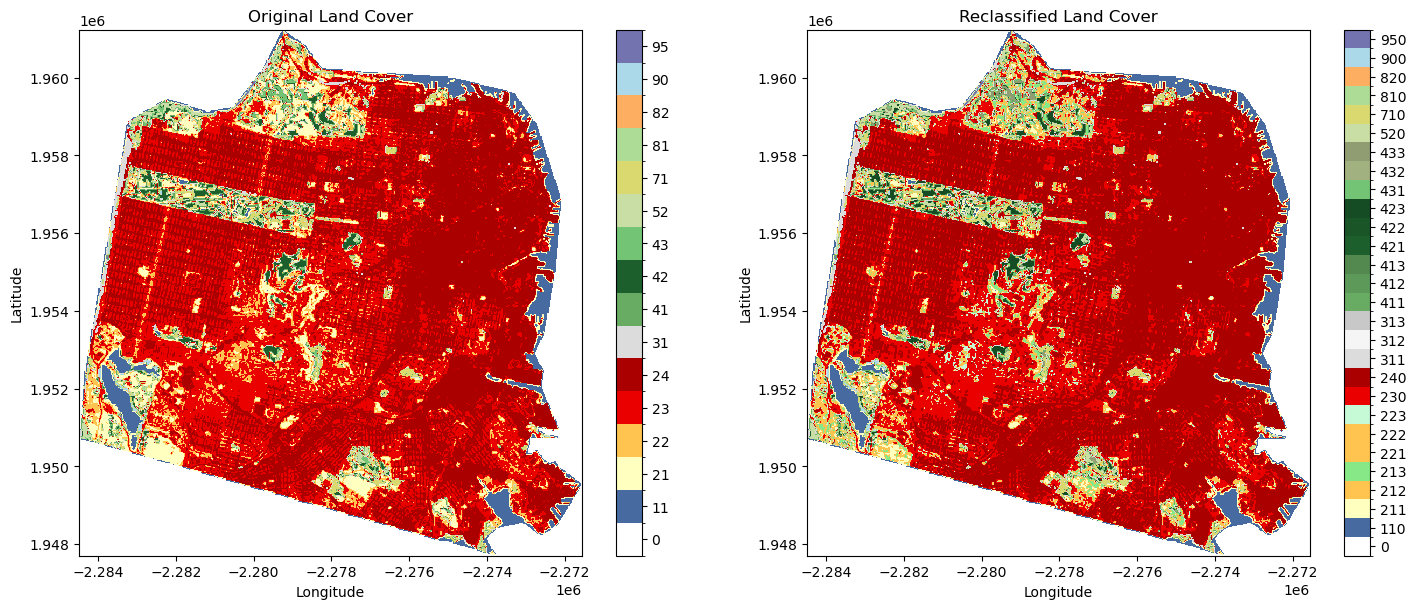

In [80]:
def calculate_midpoints(boundaries):
    """
    Calculate the midpoints between each boundary for correct tick placement.
    """
    return [(boundaries[i] + boundaries[i + 1]) / 2 for i in range(len(boundaries) - 1)]


def plot_land_covers_side_by_side(landcover, reclassified, landcover_meta):
    """
    Plot the original and reclassified land cover side by side using NLCD colors.
    """

    # Plotting the original land cover
    plt.figure(figsize=(15, 6))
    
    # Plot 1: Original Land Cover
    plt.subplot(1, 2, 1)
    original_codes = np.unique(landcover)
    original_cmap_colors = np.array([nlcd_colors[code] for code in original_codes]) / 255.0
    original_cmap = ListedColormap(original_cmap_colors)
    original_boundaries = np.concatenate(([original_codes[0] - 0.5], original_codes + 0.5))
    original_norm = BoundaryNorm(original_boundaries, original_cmap.N)
    
    plt.imshow(landcover, cmap=original_cmap, norm=original_norm,
               extent=(landcover_meta['transform'][2], landcover_meta['transform'][2] + landcover_meta['transform'][0] * landcover.shape[1],
                       landcover_meta['transform'][5] + landcover_meta['transform'][4] * landcover.shape[0], landcover_meta['transform'][5]))
    plt.title('Original Land Cover')
    
    original_ticks = calculate_midpoints(original_boundaries)
    plt.colorbar(ticks=original_ticks, format='%d').ax.set_yticklabels([str(int(code)) for code in original_codes])
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Plot 2: Reclassified Land Cover
    plt.subplot(1, 2, 2)
    reclassified_codes = np.unique(reclassified)
    reclassified_cmap_colors = np.array([extended_colors[code] for code in reclassified_codes]) / 255.0
    reclassified_cmap = ListedColormap(reclassified_cmap_colors)
    reclassified_boundaries = np.concatenate(([reclassified_codes[0] - 0.5], reclassified_codes + 0.5))
    reclassified_norm = BoundaryNorm(reclassified_boundaries, reclassified_cmap.N)
    
    plt.imshow(reclassified, cmap=reclassified_cmap, norm=reclassified_norm,
               extent=(landcover_meta['transform'][2], landcover_meta['transform'][2] + landcover_meta['transform'][0] * reclassified.shape[1],
                       landcover_meta['transform'][5] + landcover_meta['transform'][4] * reclassified.shape[0], landcover_meta['transform'][5]))
    plt.title('Reclassified Land Cover')
    
    reclassified_ticks = calculate_midpoints(reclassified_boundaries)
    plt.colorbar(ticks=reclassified_ticks, format='%d').ax.set_yticklabels([str(int(code)) for code in reclassified_codes])
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.tight_layout()
    plt.show()



# Plot the original and reclassified land cover side by side
plot_land_covers_side_by_side(landcover, reclassified, landcover_meta)


### Plot reclassified only

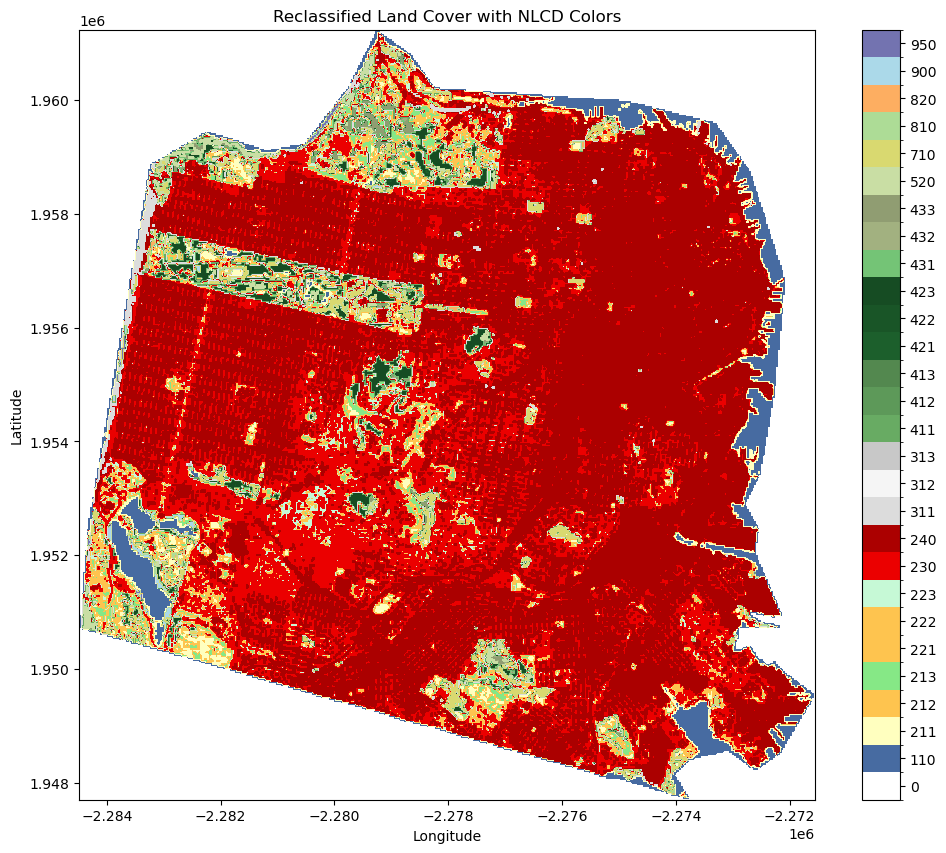

In [81]:

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_reclassified_landcover(landcover, reclassified, landcover_meta):
    """
    Plot the reclassified land cover using NLCD colors, with additional colors for new classes.

    Parameters:
    landcover (numpy.ndarray): The original land cover raster array.
    reclassified (numpy.ndarray): The reclassified land cover raster array.
    landcover_meta (dict): Metadata of the land cover raster for extent information.
    """

    # Get the unique codes in the reclassified land cover data
    unique_codes = np.unique(reclassified)

    # Filter extended_colors to include only the present codes
    filtered_colors = {code: extended_colors[code] for code in unique_codes if code in extended_colors}
    # print("Unique codes in the reclassified data:\n", unique_codes)
    # print(filtered_colors)


    reclassified_codes = unique_codes
    reclassified_cmap_colors = np.array([extended_colors[code] for code in reclassified_codes]) / 255.0
    cmap = ListedColormap(reclassified_cmap_colors)
    boundaries = np.concatenate(([reclassified_codes[0] - 0.5], reclassified_codes + 0.5))
    norm = BoundaryNorm(boundaries, cmap.N)
    ticks = calculate_midpoints(boundaries)

    # Plot the reclassified land cover
    plt.figure(figsize=(12, 10))
    plt.imshow(reclassified, cmap=cmap, norm=norm,
               extent=(landcover_meta['transform'][2], landcover_meta['transform'][2] + landcover_meta['transform'][0] * reclassified.shape[1],
                       landcover_meta['transform'][5] + landcover_meta['transform'][4] * reclassified.shape[0], landcover_meta['transform'][5]))
    plt.title('Reclassified Land Cover with NLCD Colors')
    plt.colorbar(ticks=ticks, format='%d').ax.set_yticklabels([str(int(code)) for code in reclassified_codes])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


# Plot the reclassified land cover with the NLCD colors
plot_reclassified_landcover(landcover, reclassified, landcover_meta)


### Zoom in 

[130, 230, 115, 215]


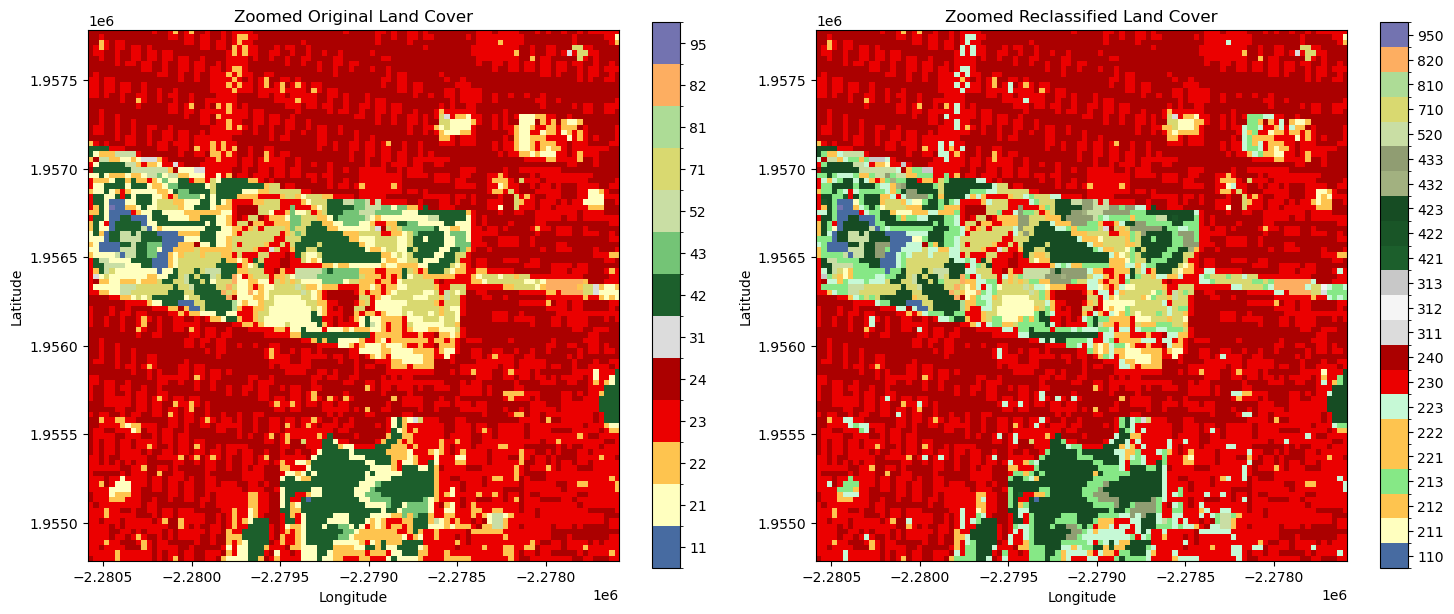

In [82]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm


def calculate_zoom_bbox(landcover_meta, central_x, central_y, area_size_m=1000):
    """
    Calculate the zoom bounding box (in pixel coordinates) for a specified area size (in meters).
    """
    # Calculate pixel size in meters
    pixel_size_x = landcover_meta['transform'][0]
    pixel_size_y = -landcover_meta['transform'][4]

    # Number of pixels for specified area in each direction
    pixels_per_km_x = int(area_size_m / pixel_size_x)
    pixels_per_km_y = int(area_size_m / pixel_size_y)
    
    # Convert central coordinates to pixel coordinates
    central_pixel_x = int((central_x - landcover_meta['transform'][2]) / pixel_size_x)
    central_pixel_y = int((central_y - landcover_meta['transform'][5]) / pixel_size_y)
    
    # Define zoom_bbox (area_size_m² centered around central point)
    zoom_bbox = [
        central_pixel_x - pixels_per_km_x // 2,
        central_pixel_x + pixels_per_km_x // 2,
        central_pixel_y - pixels_per_km_y // 2,
        central_pixel_y + pixels_per_km_y // 2
    ]
    
    return zoom_bbox

def plot_land_covers_zoomed(landcover, reclassified, landcover_meta, zoom_bbox):
    """
    Plot the original and reclassified land cover side by side using NLCD colors.
    Calculate midpoints for each boundary to correctly place ticks.
    Also zoom in on a specific region defined by zoom_bbox.
    """

    
    # Extract the zoom region from the landcover and reclassified arrays
    zoom_x_min, zoom_x_max, zoom_y_min, zoom_y_max = zoom_bbox

    # Ensure the zoomed region is within bounds
    zoom_x_max = min(zoom_x_max, landcover.shape[1])
    zoom_y_max = min(zoom_y_max, landcover.shape[0])
    
    zoomed_landcover = landcover[zoom_y_min:zoom_y_max, zoom_x_min:zoom_x_max]
    zoomed_reclassified = reclassified[zoom_y_min:zoom_y_max, zoom_x_min:zoom_x_max]
    
    # Check if the zoomed arrays are non-empty
    if zoomed_landcover.size == 0 or zoomed_reclassified.size == 0:
        print("Error: The zoomed region is empty. Please check the bounding box coordinates.")
        return
    
    # Calculate the extent of the zoomed region
    zoomed_extent = (
        landcover_meta['transform'][2] + zoom_x_min * landcover_meta['transform'][0],
        landcover_meta['transform'][2] + zoom_x_max * landcover_meta['transform'][0],
        landcover_meta['transform'][5] + zoom_y_max * landcover_meta['transform'][4],
        landcover_meta['transform'][5] + zoom_y_min * landcover_meta['transform'][4]
    )

    # Plotting the zoomed region
    plt.figure(figsize=(15, 6))
    
    # Plot 1: Zoomed Original Land Cover
    plt.subplot(1, 2, 1)
    original_codes = np.unique(zoomed_landcover)
    if original_codes.size == 0:
        print("No unique land cover codes found in the zoomed region.")
        return
    original_cmap_colors = np.array([nlcd_colors[code] for code in original_codes]) / 255.0
    original_cmap = ListedColormap(original_cmap_colors)
    original_boundaries = np.concatenate(([original_codes[0] - 0.5], original_codes + 0.5))
    original_norm = BoundaryNorm(original_boundaries, original_cmap.N)
    
    plt.imshow(zoomed_landcover, cmap=original_cmap, norm=original_norm, extent=zoomed_extent)
    plt.title('Zoomed Original Land Cover')
    
    original_ticks = calculate_midpoints(original_boundaries)
    plt.colorbar(ticks=original_ticks, format='%d').ax.set_yticklabels([str(int(code)) for code in original_codes])
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Plot 2: Zoomed Reclassified Land Cover
    plt.subplot(1, 2, 2)
    reclassified_codes = np.unique(zoomed_reclassified)
    if reclassified_codes.size == 0:
        print("No unique reclassified land cover codes found in the zoomed region.")
        return
    reclassified_cmap_colors = np.array([extended_colors[code] for code in reclassified_codes]) / 255.0
    reclassified_cmap = ListedColormap(reclassified_cmap_colors)
    reclassified_boundaries = np.concatenate(([reclassified_codes[0] - 0.5], reclassified_codes + 0.5))
    reclassified_norm = BoundaryNorm(reclassified_boundaries, reclassified_cmap.N)
    
    plt.imshow(zoomed_reclassified, cmap=reclassified_cmap, norm=reclassified_norm, extent=zoomed_extent)
    plt.title('Zoomed Reclassified Land Cover')
    
    reclassified_ticks = calculate_midpoints(reclassified_boundaries)
    plt.colorbar(ticks=reclassified_ticks, format='%d').ax.set_yticklabels([str(int(code)) for code in reclassified_codes])
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.tight_layout()
    plt.show()



# Define the central coordinates for San Francisco (in meters, using Albers Conical Equal Area)
central_x = -2279073  # Example X coordinate (meters in Albers)
central_y = 1966187  # Example Y coordinate (meters in Albers)

# Calculate the zoom bounding box for 1km² around the central point
zoom_bbox = calculate_zoom_bbox(landcover_meta, central_x, central_y, area_size_m=3000)
print(zoom_bbox)

# Plot the original and reclassified land cover side by side with zoomed-in region
plot_land_covers_zoomed(landcover, reclassified, landcover_meta, zoom_bbox)
